In [1]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import matplotlib.pyplot as plt
from scipy import stats
from imblearn.over_sampling import SMOTE
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import OneHotEncoder, LabelEncoder



import joblib

In [2]:
data = pd.read_csv("train.csv", sep = ",")

In [3]:
asia = ["Philippines", "India", "South", "China", "Vietnam", "Japan", "Taiwan", "Iran", "Thailand", "Cambodia", "Laos", "Hong"]
europe = ["Germany", "England", "Italy", "Poland", "Portugal", "Greece", "France", "Ireland", "Yugoslavia", "Hungary", "Scotland", "Netherlands"]
north_america = ["USA", "Canada"]
central_america = ["Mexico", "Puerto-Rico", "El-Salvador", "Cuba", "Jamaica", "Dominican-Republic", "Guatemala", "Haiti", "Nicaragua", "Caribbean", "Honduras"]
south_america = ["Columbia", "Peru", "Ecuador"]

for i in range(len(data)):
    if data.loc[i, "F13"] in asia:
        data.F13.replace(data.loc[i, "F13"], "asia", inplace = True)
    elif data.loc[i, "F13"] in europe:
        data.F13.replace(data.loc[i, "F13"], "europe", inplace = True)
    elif data.loc[i, "F13"] in north_america:
        data.F13.replace(data.loc[i, "F13"], "north_america", inplace = True)
    elif data.loc[i, "F13"] in central_america:
        data.F13.replace(data.loc[i, "F13"], "central_america", inplace = True)
    elif data.loc[i, "F13"] in south_america:
        data.F13.replace(data.loc[i, "F13"], "south_america", inplace = True)

# for i in range(len(test)):
#     if test.loc[i, "F13"] in asia:
#         test.F13.replace(test.loc[i, "F13"], "asia", inplace = True)
#     if test.loc[i, "F13"] in europe:
#         test.F13.replace(test.loc[i, "F13"], "europe", inplace = True)
#     if test.loc[i, "F13"] in north_america:
#         test.F13.replace(test.loc[i, "F13"], "north_america", inplace = True)
#     if test.loc[i, "F13"] in central_america:
#         test.F13.replace(test.loc[i, "F13"], "central_america", inplace = True)
#     if test.loc[i, "F13"] in south_america:
#         test.F13.replace(test.loc[i, "F13"], "south_america", inplace = True)

In [4]:
data.head()

,F0,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,Y
0,39,K1,77516,R1,13,Q1,P1,M1,caucasian,Male,2174,0,40,north_america,0
1,50,K2,83311,R1,13,Q2,P2,M2,caucasian,Male,0,0,13,north_america,0
2,38,K3,215646,R2,9,Q3,P3,M1,caucasian,Male,0,0,40,north_america,0
3,53,K3,234721,R3,7,Q2,P3,M2,black,Male,0,0,40,north_america,0
4,28,K3,338409,R1,13,Q2,P4,M3,black,Female,0,0,40,central_america,0


In [4]:
# Colonne feature categoriche
colF1 = ['K1', 'K2', 'K3', 'K4', 'K5', 'K6', 'K7', 'K8']
colF3 = ['R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'R10', 'R11', 'R12', 'R13', 'R14', 'R15', 'R16']
colF5 = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7']
colF6 = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14']
colF7 = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6']
colF8 = ['caucasian', 'black', 'asian', 'american', 'other']
colF9 = ['Male', 'Female']
colF13 = ['asia', 'europe', 'north_america', 'central_america', 'south_america']

# Codifica delle feature categoriche
data.F1.replace(colF1, [0, 1, 2, 3, 4, 5, 6, 7], inplace = True)
data.F3.replace(colF3, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], inplace = True)
data.F5.replace(colF5, [0, 1, 2, 3, 4, 5, 6], inplace = True)
data.F6.replace(colF6, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], inplace = True)
data.F7.replace(colF7, [0, 1, 2, 3, 4, 5], inplace = True)
data.F8.replace(colF8, [0, 1, 2, 3, 4], inplace = True)
data.F9.replace(colF9, [0, 1], inplace = True)
data.F13.replace(colF13, [0, 1, 2, 3, 4], inplace = True)

# test.F1.replace(colF1, [0, 1, 2, 3, 4, 5, 6, 7], inplace = True)
# test.F3.replace(colF3, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], inplace = True)
# test.F5.replace(colF5, [0, 1, 2, 3, 4, 5, 6], inplace = True)
# test.F6.replace(colF6, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], inplace = True)
# test.F7.replace(colF7, [0, 1, 2, 3, 4, 5], inplace = True)
# test.F8.replace(colF8, [0, 1, 2, 3, 4], inplace = True)
# test.F9.replace(colF9, [0, 1], inplace = True)
# test.F13.replace(colF13, [0, 1, 2, 3, 4], inplace = True)

In [5]:
x_train = data.iloc[:, :-1].values
y_train = data.iloc[:, -1].values
print(x_train.shape)
print(y_train.shape)

(32561, 14)
(32561,)


In [6]:
# Imputazione dei valori NaN tramite SimpleImputer, con la strategia che sostituisce i valori mancanti con la moda dei valori della feature
print("SimpleImputer")
imp = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
x_train_notnan = imp.fit_transform(x_train)
# x_test_notnan = imp.transform(x_test)
print(x_train_notnan[pd.isna(x_train[:,0]),0][0:10])
# print(x_test_notnan[pd.isna(x_test[:,0]),0][0:10])

SimpleImputer
[]


In [7]:
# Creazione DataFrame da insiemi di train e test dopo l'imputazione dei valori mancanti 
colF = ['F0','F1','F2','F3','F4','F5','F6','F7','F8','F9','F10','F11','F12','F13']

training_set_df = pd.DataFrame(x_train_notnan, columns = colF)
# test_set_df = pd.DataFrame(x_test_notnan, columns = colF)

In [9]:
training_set_df.head()

,F0,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13
0,39.0,0.0,77516.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,2174.0,0.0,40.0,2.0
1,50.0,1.0,83311.0,0.0,13.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,13.0,2.0
2,38.0,2.0,215646.0,1.0,9.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,40.0,2.0
3,53.0,2.0,234721.0,2.0,7.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,40.0,2.0
4,28.0,2.0,338409.0,0.0,13.0,1.0,3.0,2.0,1.0,1.0,0.0,0.0,40.0,3.0


In [13]:
categorical = ['F1','F3','F5','F6','F7','F8','F9','F13']
data_x_categorical = pd.DataFrame()

for i in categorical:
    data_x_categorical=pd.concat([data_x_categorical, training_set_df[i]], axis= 1)

data_x_categorical.head()

,F1,F3,F5,F6,F7,F8,F9,F13
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
1,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0
2,2.0,1.0,2.0,2.0,0.0,0.0,0.0,2.0
3,2.0,2.0,1.0,2.0,1.0,1.0,0.0,2.0
4,2.0,0.0,1.0,3.0,2.0,1.0,1.0,3.0


In [21]:
one_hot_encoder = OneHotEncoder() # rimuovo una variabile dummy per ogni feature categorica in modo da non avere collinearità
one_hot_encoder.fit(data_x_categorical)
transformed = one_hot_encoder.transform(data_x_categorical)


In [22]:
print(transformed.toarray())

[[1. 0. 1. ... 0. 1. 0.]
 [0. 1. 1. ... 0. 1. 0.]
 [1. 0. 0. ... 0. 1. 0.]
 ...
 [1. 0. 0. ... 0. 1. 0.]
 [1. 0. 0. ... 0. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]]


In [23]:
data_x_categorical = pd.DataFrame(transformed.toarray(), columns = one_hot_encoder.get_feature_names(), index = data_x_categorical.index)

c:\Users\tagli\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [14]:
# for i in range (0, len(colF1)):
#     training_set_df1 = training_set_df.rename(columns = {i: colF1[i]})
# for i in range (0, len(colF3)):
#     training_set_df3 = training_set_df.rename(columns = {i: colF3[i]})
# for i in range (0, len(colF5)):
#     training_set_df5 = training_set_df.rename(columns = {i: colF5[i]})
# for i in range (0, len(colF6)):
#     training_set_df6 = training_set_df.rename(columns = {i: colF6[i]})
# for i in range (0, len(colF7)):
#     training_set_df7 = training_set_df.rename(columns = {i: colF7[i]})
# for i in range (0, len(colF8)):
#     training_set_df8 = training_set_df.rename(columns = {i: colF8[i]})
# for i in range (0, len(colF9)):
#     training_set_df9 = training_set_df.rename(columns = {i: colF9[i]})
# for i in range (0, len(colF13)):
#     training_set_df13 = training_set_df.rename(columns = {i: colF13[i]})

In [15]:
training_set_df.head()


,F0,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13
0,39.0,0.0,77516.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,2174.0,0.0,40.0,2.0
1,50.0,1.0,83311.0,0.0,13.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,13.0,2.0
2,38.0,2.0,215646.0,1.0,9.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,40.0,2.0
3,53.0,2.0,234721.0,2.0,7.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,40.0,2.0
4,28.0,2.0,338409.0,0.0,13.0,1.0,3.0,2.0,1.0,1.0,0.0,0.0,40.0,3.0


In [16]:
# # Creazione newdf e newdftest con la sostituzione delle colonne generate con la codifica
# training_set_df = pd.concat([training_set_df, training_set_df1, training_set_df3, training_set_df5, training_set_df6, training_set_df7, training_set_df8, training_set_df9, training_set_df13], axis = 1)
 
# training_set_df = training_set_df.drop(["F1", "F3", "F5", "F6", "F7", "F8", "F9", "F13"], axis = 1)


In [24]:
data_x_categorical.head()

,x0_0.0,x0_1.0,x1_0.0,x1_1.0,x2_0.0,x2_1.0,x3_0.0,x3_1.0,x4_0.0,x4_1.0,...,x50_0.0,x50_1.0,x51_0.0,x51_1.0,x52_0.0,x52_1.0,x53_0.0,x53_1.0,x54_0.0,x54_1.0
0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
1,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
2,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
3,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
4,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


In [9]:
# Codifica OneHot contemporaneamente su training_set_df e test_set_df
OneHotF1 = pd.get_dummies(training_set_df.F1, columns = colF1)
OneHotF3 = pd.get_dummies(training_set_df.F3, columns = colF3)
OneHotF5 = pd.get_dummies(training_set_df.F5, columns = colF5)
OneHotF6 = pd.get_dummies(training_set_df.F6, columns = colF6)
OneHotF7 = pd.get_dummies(training_set_df.F7, columns = colF7)
OneHotF8 = pd.get_dummies(training_set_df.F8, columns = colF8)
OneHotF9 = pd.get_dummies(training_set_df.F9, columns = colF9)
OneHotF13 = pd.get_dummies(training_set_df.F13, columns = colF13)

for i in range (0, len(colF1)):
    OneHotF1 = OneHotF1.rename(columns = {i: colF1[i]})
for i in range (0, len(colF3)):
    OneHotF3 = OneHotF3.rename(columns = {i: colF3[i]})
for i in range (0, len(colF5)):
    OneHotF5 = OneHotF5.rename(columns = {i: colF5[i]})
for i in range (0, len(colF6)):
    OneHotF6 = OneHotF6.rename(columns = {i: colF6[i]})
for i in range (0, len(colF7)):
    OneHotF7 = OneHotF7.rename(columns = {i: colF7[i]})
for i in range (0, len(colF8)):
    OneHotF8 = OneHotF8.rename(columns = {i: colF8[i]})
for i in range (0, len(colF9)):
    OneHotF9 = OneHotF9.rename(columns = {i: colF9[i]})
for i in range (0, len(colF13)):
    OneHotF13 = OneHotF13.rename(columns = {i: colF13[i]})


In [10]:
# Creazione newdf e newdftest con la sostituzione delle colonne generate con la codifica
training_set_df = pd.concat([training_set_df, OneHotF1, OneHotF3, OneHotF5, OneHotF6, OneHotF7, OneHotF8, OneHotF9, OneHotF13], axis = 1)
 
training_set_df = training_set_df.drop(["F1", "F3", "F5", "F6", "F7", "F8", "F9", "F13"], axis = 1)


In [11]:
training_set_df.head()

,F0,F2,F4,F10,F11,F12,K1,K2,K3,K4,...,asian,american,other,Male,Female,asia,europe,north_america,central_america,south_america
0,39.0,77516.0,13.0,2174.0,0.0,40.0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
1,50.0,83311.0,13.0,0.0,0.0,13.0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
2,38.0,215646.0,9.0,0.0,0.0,40.0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
3,53.0,234721.0,7.0,0.0,0.0,40.0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
4,28.0,338409.0,13.0,0.0,0.0,40.0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0


In [12]:
# #feature transformation
# X['F2'] = np.log10(X['F2']+1)
# X['F10'] = np.log2(X['F10']+1)
# X['F11'] = np.log2(X['F11']+1)

# # combino valori numerici con categorici
# X = pd.concat([X,data_x_categorical],axis=1)

# X = X.astype(float)
# Y.Y = Y.Y.astype(float)


In [13]:
training_set_df.head()

,F0,F2,F4,F10,F11,F12,K1,K2,K3,K4,...,asian,american,other,Male,Female,asia,europe,north_america,central_america,south_america
0,39.0,77516.0,13.0,2174.0,0.0,40.0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
1,50.0,83311.0,13.0,0.0,0.0,13.0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
2,38.0,215646.0,9.0,0.0,0.0,40.0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
3,53.0,234721.0,7.0,0.0,0.0,40.0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
4,28.0,338409.0,13.0,0.0,0.0,40.0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0


In [14]:
# pipelineSelection.optimize(x_train, y_train)

In [15]:
y_training_df = pd.DataFrame(y_train, columns = ["Y"])


In [16]:
training_target_df = pd.concat([training_set_df, y_training_df], axis = 1)


In [17]:
z_scores = stats.zscore(training_target_df["F2"])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3)
training_target_df = training_target_df[filtered_entries]

training_target_df.head()

,F0,F2,F4,F10,F11,F12,K1,K2,K3,K4,...,american,other,Male,Female,asia,europe,north_america,central_america,south_america,Y
0,39.0,77516.0,13.0,2174.0,0.0,40.0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1,50.0,83311.0,13.0,0.0,0.0,13.0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,0
2,38.0,215646.0,9.0,0.0,0.0,40.0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0
3,53.0,234721.0,7.0,0.0,0.0,40.0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0
4,28.0,338409.0,13.0,0.0,0.0,40.0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0


In [18]:
x_train_notnan = training_target_df.iloc[:, :-1].values
print(x_train_notnan.shape)
y_train = training_target_df.iloc[:, -1].values
print(y_train.shape)

(32214, 69)
(32214,)


In [19]:
# Scaling con StandardScaler

print("StandardScaler")
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_notnan)
# x_test_scaled = scaler.transform(x_test_notnan)

print("Media distribuzione di partenza: {}".format(np.mean(x_train_notnan, axis=0)))
print("Media distribuzione scalata: {}".format(np.mean(x_train_scaled, axis=0)))

print("Deviazione standard distribuzione di partenza: {}".format(np.std(x_train_notnan, axis=0)))
print("Deviazione standard distribuzione scalata: {}".format(np.std(x_train_scaled, axis=0)))

# print("Media distribuzione di partenza: {}".format(np.mean(x_test_notnan, axis=0)))
# print("Media distribuzione scalata: {}".format(np.mean(x_test_scaled, axis=0)))

# print("Deviazione standard distribuzione di partenza: {}".format(np.std(x_test_notnan, axis=0)))
# print("Deviazione standard distribuzione scalata: {}".format(np.std(x_test_scaled, axis=0)))

StandardScaler
Media distribuzione di partenza: [3.86152604e+01 1.85068537e+05 1.00848078e+01 1.07945136e+03
 8.76844229e+01 4.04416713e+01 3.98894890e-02 7.84751971e-02
 7.52747253e-01 2.94281989e-02 6.43198609e-02 3.44881108e-02
 4.34593655e-04 2.17296827e-04 1.64276402e-01 3.22437450e-01
 3.61023158e-02 5.29583411e-02 1.56764140e-02 2.24033029e-01
 3.29980754e-02 4.26522630e-02 1.98981809e-02 1.27584280e-02
 1.78183399e-02 1.01198237e-02 2.85279692e-02 5.09095424e-03
 1.52107779e-03 1.31309369e-02 3.27745701e-01 4.60389893e-01
 1.36524492e-01 1.27894704e-02 3.12597008e-02 6.82932886e-04
 3.06078103e-02 1.15663997e-01 1.25038803e-01 4.18451605e-02
 1.84298752e-01 1.01136152e-01 1.12342460e-01 1.25628609e-01
 4.88607438e-02 3.04525982e-02 6.15570870e-02 2.84037996e-02
 1.99292233e-02 2.79381635e-04 4.56323338e-03 2.55044391e-01
 4.05475880e-01 4.82709381e-02 1.55553486e-01 1.05606258e-01
 3.00490470e-02 8.55776991e-01 9.39032719e-02 3.22530577e-02
 9.65418762e-03 8.41249146e-03 6.6893

In [20]:
smote = SMOTE(random_state = 0, sampling_strategy = 'not majority', k_neighbors = 10, n_jobs = -1)
x_train_scaled, y_train = smote.fit_resample(x_train_scaled, y_train)
print(x_train_scaled.shape, y_train.shape)
print(x_train_scaled)

(48906, 69) (48906,)
[[ 0.02818334 -1.13747952  1.13409202 ...  0.29766597 -0.20025168
  -0.05959364]
 [ 0.83396665 -1.07619139  1.13409202 ...  0.29766597 -0.20025168
  -0.05959364]
 [-0.04506969  0.32338835 -0.42202087 ...  0.29766597 -0.20025168
  -0.05959364]
 ...
 [-0.69084479 -1.60377104 -0.42202087 ...  0.29766597 -0.20025168
  -0.05959364]
 [-0.02490731  0.87173017  0.7450638  ...  0.29766597 -0.20025168
  -0.05959364]
 [ 0.68179709 -0.12037052 -0.42202087 ...  0.29766597 -0.20025168
  -0.05959364]]


In [21]:
training_set_df.head(20)

,F0,F2,F4,F10,F11,F12,K1,K2,K3,K4,...,asian,american,other,Male,Female,asia,europe,north_america,central_america,south_america
0,39.0,77516.0,13.0,2174.0,0.0,40.0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
1,50.0,83311.0,13.0,0.0,0.0,13.0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
2,38.0,215646.0,9.0,0.0,0.0,40.0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
3,53.0,234721.0,7.0,0.0,0.0,40.0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
4,28.0,338409.0,13.0,0.0,0.0,40.0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
5,37.0,284582.0,14.0,0.0,0.0,40.0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
6,49.0,160187.0,5.0,0.0,0.0,16.0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
7,52.0,209642.0,9.0,0.0,0.0,45.0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
8,31.0,45781.0,14.0,14084.0,0.0,50.0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
9,42.0,159449.0,13.0,5178.0,0.0,40.0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0


array([[<AxesSubplot:title={'center':'Y'}>]], dtype=object)

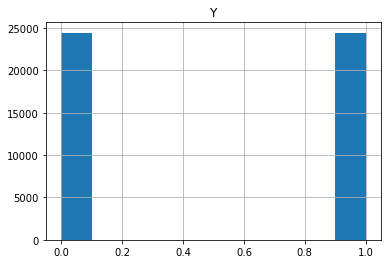

In [22]:
y_training_df = pd.DataFrame(y_train, columns = ["Y"])
y_training_df.hist()

In [23]:
from sklearn.ensemble import AdaBoostClassifier


In [ ]:

classifierADA = AdaBoostClassifier(base_estimator = DecisionTreeClassifier())

grid = dict()
# grid['n_estimators'] = [40, 200, 1000]
# grid['learning_rate'] = [.001, .01, .1, 1]

# grid['n_estimators'] = [150, 500, 1000]
# grid['learning_rate'] = [0.01, 0.1, 1]
# grid['base_estimator__max_depth'] = [1, 2, 5]
# grid['base_estimator__min_samples_split'] = [2, 3, 5]
# grid['base_estimator__min_samples_leaf'] = [2, 5, 10]

grid['n_estimators'] = [1000]
grid['learning_rate'] = [1]
grid['base_estimator__max_depth'] = [2]
grid['base_estimator__min_samples_split'] = [5]
grid['base_estimator__min_samples_leaf'] = [2, 5]

# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1, random_state = 1)

# define the grid search procedure
grid_search = GridSearchCV(estimator = classifierADA, param_grid = grid, n_jobs = -1, cv = cv, scoring = 'accuracy')

# execute the grid search
grid_fit = grid_search.fit(x_train_scaled, y_train)

# # # execute the grid search
# # y_pred_rf = grid_search.predict(x_test_scaled)

# summarize the best score and configuration
print("Best: %f using %s" % (grid_fit.best_score_ , grid_fit.best_params_))

# # CM_ADA = confusion_matrix(y_test, y_pred_rf)
# # PercADA = (CM_ADA[0,0]+CM_ADA[1,1])/CM_ADA.sum()

# # cmd = ConfusionMatrixDisplay(CM_ADA)
# # cmd.plot(cmap = "Oranges")

# # print(PercADA)

In [24]:
bestclf = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 2, min_samples_split = 2, min_samples_leaf = 5), learning_rate = 1, n_estimators = 1000)

In [27]:
bestclf.fit(x_train_scaled, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2,
                                                         min_samples_leaf=5),
                   learning_rate=1, n_estimators=1000)

In [22]:
y_pred = bestclf.predict(x_train_scaled)

0.9368673523313956


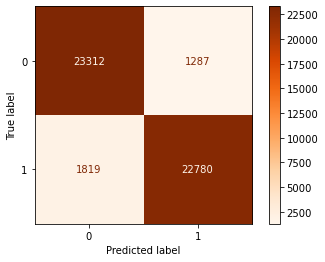

In [ ]:
CM_ADA = confusion_matrix(y_train, y_pred)
PercADA = (CM_ADA[0,0] + CM_ADA[1,1])/CM_ADA.sum()

cmd = ConfusionMatrixDisplay(CM_ADA)
cmd.plot(cmap = "Oranges")

print(PercADA)

In [28]:
# Salvo tutti gli oggetti addestrati
joblib.dump(imp, "pickles/imputer.pkl")
joblib.dump(scaler, "pickles/scaler.pkl")
joblib.dump(bestclf, "pickles/model.pkl")

['pickles/model.pkl']